In [ ]:
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from tqdm import tqdm

from torchvision import datasets
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("training on {}".format(device))

training on cuda


In [ ]:
fmnist = datasets.FashionMNIST('./datasets/FMINST',download=True,train=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./datasets/FMINST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FMINST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./datasets/FMINST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FMINST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./datasets/FMINST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FMINST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./datasets/FMINST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FMINST/FashionMNIST/raw



In [ ]:
tr_images = fmnist.data
tr_targets = fmnist.targets

### Create the dataset class
####**Note**: It's nessasry to have $__getitem__$ and $__len__$ method when creating th pytorch dataset.


In [ ]:
#create dataset
class FMINSTDataset(Dataset):

  def __init__(self,x,y):
    x = x.float()/255
    x = x.view(-1,1,28,28)
    self.x = x
    self.y = y
  
  def __getitem__(self,ix):
    x,y = self.x[ix],self.y[ix]
    return x.to(device),y.to(device)
  
  def __len__(self):
    return len(self.x)

In [ ]:
?nn.Conv2d

#### Creating the model



1.   Understant model input and output sizes - Our original image size is 28 x 28. And we are applying convolution operation with outsize as 64 and kernel size as 3. Which means the output image will have 64 channels(Feature maps). Hence, depth of the output of first convlution layer would be 64. And then we need to calculate height and with of the result image. Since this image is 28 x 28, result height(h) and width(w) will be same. Do calculate h and w we can apply below function. <br><br>

$returned\space image \space height =FLOOR(\frac {(iput\space height - kernel \space size + 2*padding \space size)}{stride} +1)$ <br><br> 

This is same for width as well. Let's calculate first conv. layer output size <br><br> 
$input\space height=28$ <br>
$kernel\space size=3$ <br>
$padding\space size=0$ <br>
$stride=1$ <br><br>

$returned\space image \space height =FLOOR(\frac {(28 - 3 + 2*0)}{1} +1)$<br>
$returned\space image \space height =26$<br>

Let's add 2x2 pooling layer. We can get returned image height and width using following equation.<br><br>

$returned\space image \space height =FLOOR(\frac {(iput\space height - kernel \space size)}{stride} +1)$ <br><br> Let's plug values to equation.

$returned\space image \space height =FLOOR(\frac {(26 - 3)}{2} +1)$<br>
$returned\space image \space height =13$<br>


---


Ok, lets add second convolution max pool layer.

$returned\space image \space height =FLOOR(\frac {(13 - 3 + 2*0)}{1} +1)$<br>
$returned\space image \space height =11$<br>

$returned\space image \space height =FLOOR(\frac {(11 - 3)}{2} +1)$<br>
$returned\space image \space height =5$<br><br>

This means after applying two convolution max pool layer, our result image size is 5 x 5.<br>

That's the end of feature extraction part. Time to build fully connected layers. To do that first we need to flatten our input came from two convo maxpool layer. Thats where we need to fidn requred hiden unites in fully connected layer. we already know image size, it's 5 x 5. Not we need to know no of feature maps returned. That equal to no of out features in last convolution layer. In our case it will be 128. So, requred hidden units is 5x5x128 = 3200.





In [ ]:
class FMINSTModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1  = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3)
    self.pool  = nn.MaxPool2d(kernel_size=2,stride=2)
    self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
    self.fc1   = nn.Linear(128*5*5,256)
    self.fc2    = nn.Linear(256,180)
    self.fc3    = nn.Linear(180,10) # our dataset has 10 classes.

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x

In [ ]:
model = FMINSTModel()

In [ ]:
summary(model=model.to(device),input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
            Conv2d-3          [-1, 128, 11, 11]          73,856
         MaxPool2d-4            [-1, 128, 5, 5]               0
            Linear-5                  [-1, 256]         819,456
            Linear-6                  [-1, 180]          46,260
            Linear-7                   [-1, 10]           1,810
Total params: 942,022
Trainable params: 942,022
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.56
Params size (MB): 3.59
Estimated Total Size (MB): 4.16
----------------------------------------------------------------


In [ ]:
def train_model(epochs=10,batch_size=32,lr=0.001):

  train = FMINSTDataset(tr_images,tr_targets)
  train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True) 

  model = FMINSTModel().to(device)
  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  losses = torch.zeros(epochs,1)
  for epoch in range(epochs):
    batch_loss = []
    for i, data in enumerate(train_dataloader, 0):
      inputs, labels = data

      optimizer.zero_grad()

      outputs = model(inputs)

      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_loss.append(loss.item())
    losses[epoch] = torch.mean(torch.tensor(batch_loss))
    sys.stdout.write("\r"+f"Epoch:{epoch} Loss:{losses[epoch].item():.3f}")
  return model,losses

In [ ]:
model,losses = train_model(epochs=8,batch_size=32)

Epoch:7 Loss:1.205

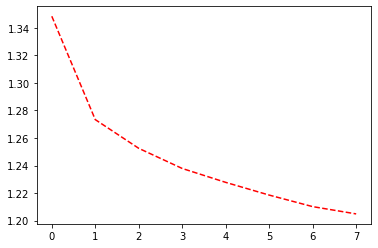

In [ ]:
plt.plot(losses.numpy(),'r--')
plt.show()

In [ ]:
tr_images[0].size()

torch.Size([28, 28])

In [ ]:
train = FMINSTDataset(tr_images,tr_targets)

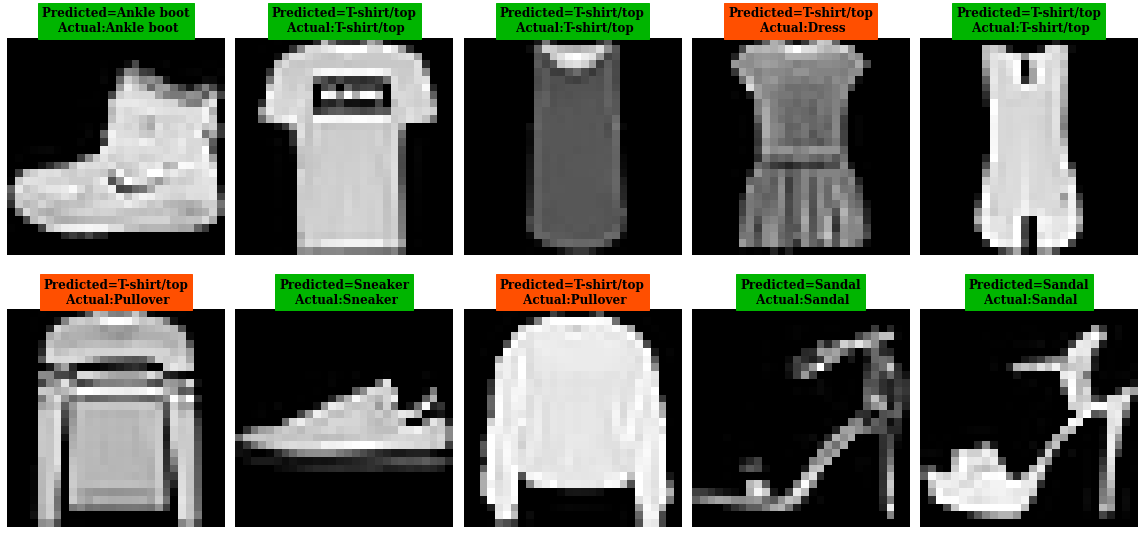

In [ ]:
_,ax = plt.subplots(2,5,figsize=(16,8))
axi = ax.flatten()
for i in range(10):
  img = train.x[i].view(-1,1,28,28)
  pred = model(img)
  pred_label = fmnist.classes[pred[0].argmax()]
  actual_label = fmnist.classes[train.y[i]]
  if pred_label==actual_label:
    color = '#00B500'
  else:
    color = '#FF4F00'
  axi[i].imshow(img.view(28,28),cmap='gray')
  axi[i].set_title(f"Predicted={pred_label}\n Actual:{actual_label}",fontfamily='serif',fontweight='semibold',backgroundcolor=color)
  axi[i].axis('off')

plt.tight_layout()
plt.show()

### Apply image augmentation methods on dataset.

In [ ]:
import imgaug.augmenters as iaa

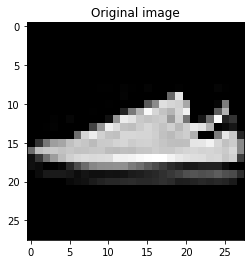

In [ ]:
plt.imshow(tr_images[6], cmap='gray')
plt.title('Original image')
plt.show()

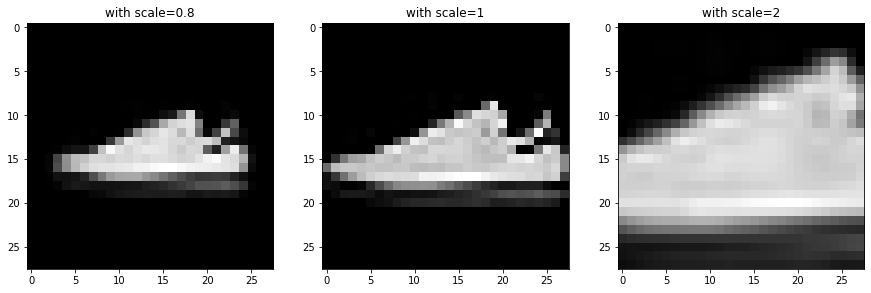

In [ ]:
img_id = 6
_,ax = plt.subplots(1,3,figsize=(15,5))

for i,x in enumerate([0.8,1,2]):
  augmenter  = iaa.Affine(scale=x)
  ax[i].imshow(augmenter.augment_image(tr_images[img_id].numpy()),cmap='gray')
  ax[i].set_title(f'with scale={x}')

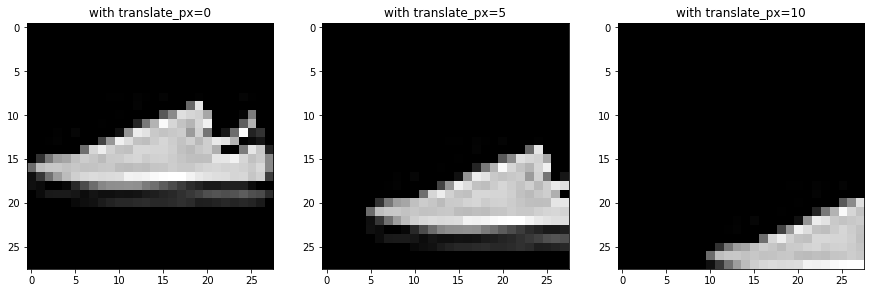

In [ ]:
img_id = 6
_,ax = plt.subplots(1,3,figsize=(15,5))

for i,x in enumerate([0,5,10]):
  augmenter  = iaa.Affine(translate_px=x)
  ax[i].imshow(augmenter.augment_image(tr_images[img_id].numpy()),cmap='gray')
  ax[i].set_title(f'with translate_px={x}')

plt.show()

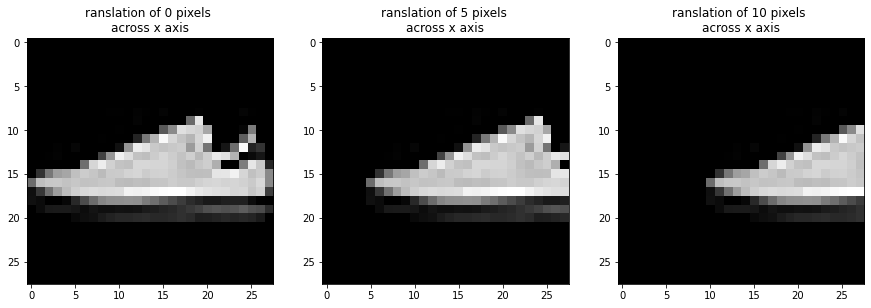

In [ ]:
img_id = 6
_,ax = plt.subplots(1,3,figsize=(15,5))

for i,x in enumerate([0,5,10]):
  augmenter  =  iaa.Affine(translate_px={'x':x,'y':0})
  ax[i].imshow(augmenter.augment_image(tr_images[img_id].numpy()),cmap='gray')
  ax[i].set_title(f'ranslation of {x} pixels \nacross x axis')

plt.show()

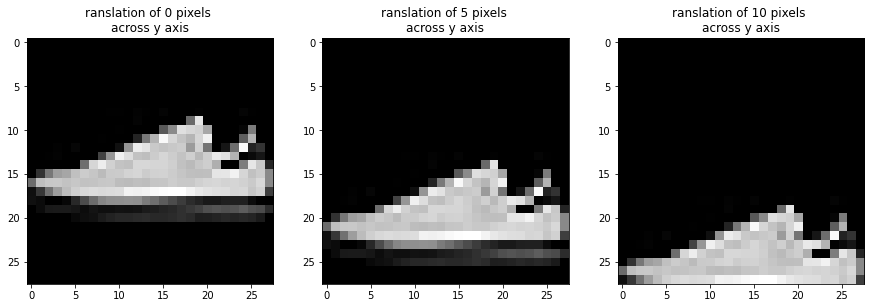

In [ ]:
img_id = 6
_,ax = plt.subplots(1,3,figsize=(15,5))

for i,x in enumerate([0,5,10]):
  augmenter  =  iaa.Affine(translate_px={'x':0,'y':x})
  ax[i].imshow(augmenter.augment_image(tr_images[img_id].numpy()),cmap='gray')
  ax[i].set_title(f'ranslation of {x} pixels \nacross y axis')

plt.show()

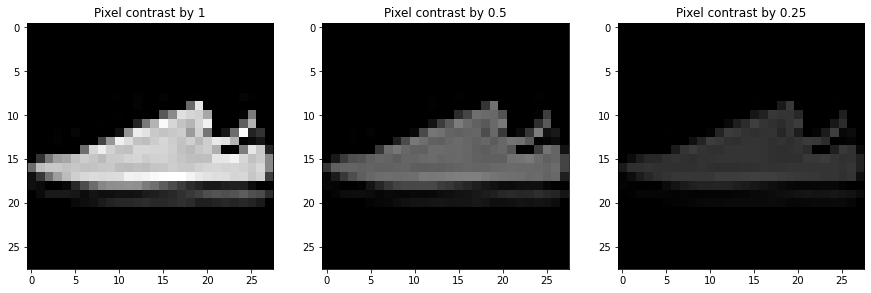

In [ ]:
img_id = 6
_,ax = plt.subplots(1,3,figsize=(15,5))

for i,x in enumerate([1,0.5,0.25]):
  augmenter   = iaa.Multiply(x)
  ax[i].imshow(augmenter.augment_image(tr_images[img_id].numpy()), cmap='gray',vmin = 0, vmax = 255)
  ax[i].set_title(f'Pixel contrast by {x}')

plt.show()

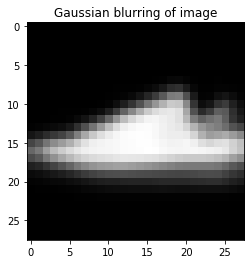

In [ ]:
aug = iaa.GaussianBlur(sigma=1)
plt.imshow(aug.augment_image(tr_images[img_id]), cmap='gray')
plt.title('Gaussian blurring of image')
plt.show()

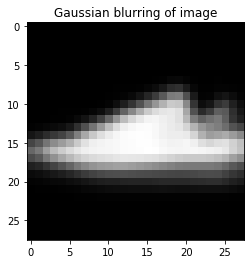

In [ ]:
aug = iaa.GaussianBlur(sigma=1)
plt.imshow(aug.augment_image(tr_images[img_id]), cmap='gray')
plt.title('Gaussian blurring of image')
plt.show()

In [ ]:
seq = iaa.Sequential([
                      iaa.Dropout(p=0.2),
                      iaa.Affine(rotate=(-30,30))
                      ], 
                     random_order= True)

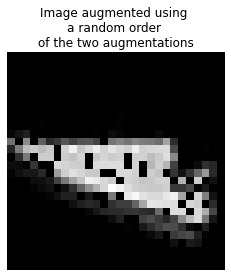

In [ ]:
plt.imshow(seq.augment_image(tr_images[img_id]), cmap='gray')
plt.title('Image augmented using \na random order \nof the two augmentations')
plt.axis('off')
plt.show()

### Let's add augmentation into train images

In [ ]:
aug = iaa.Sequential([
    iaa.Affine(translate_px={'x':(-10,10)},
        mode='constant'),
])

In [ ]:
class FMINSTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x, y
    def __len__(self): return len(self.x)

    def collate_fn(self, batch):
        'logic to modify a batch of images'
        ims, classes = list(zip(*batch))
        if self.aug: ims=self.aug.augment_images(images=ims)
        ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
        classes = torch.tensor(classes).to(device)
        return ims, classes

In [ ]:
def train_model(epochs=10,batch_size=32,lr=0.001):

  train = FMINSTDataset(tr_images, tr_targets, aug=aug)
  train_dataloader = DataLoader(train, batch_size=batch_size,collate_fn=train.collate_fn, shuffle=True) 

  model = FMINSTModel().to(device)
  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  losses = torch.zeros(epochs,1)
  for epoch in range(epochs):
    batch_loss = []
    for i, data in enumerate(train_dataloader, 0):
      inputs, labels = data

      optimizer.zero_grad()

      outputs = model(inputs)

      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_loss.append(loss.item())
    losses[epoch] = torch.mean(torch.tensor(batch_loss))
    sys.stdout.write("\r"+f"Epoch:{epoch} Loss:{losses[epoch].item():.3f}")
  return model,losses

In [ ]:
model,loss=train_model(epochs=8)

Epoch:7 Loss:1.083

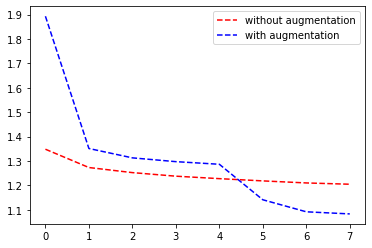

In [ ]:
plt.plot(losses.numpy(),'r--',label='without augmentation')
plt.plot(loss.numpy(),'b--',label='with augmentation')
plt.legend()
plt.show()

### Let's investigate leared kernels (filters)

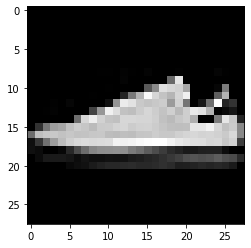

In [ ]:
im, c = tr_images[img_id],tr_targets[img_id]
plt.imshow(im.cpu(),cmap='gray')
plt.show()

first_layer = nn.Sequential(*list(model.to(device).children())[:1])

In [ ]:
first_layer

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
)

In [ ]:
intermediate_output = first_layer(im.view(-1,1,28,28).to(device).float())[0].detach()

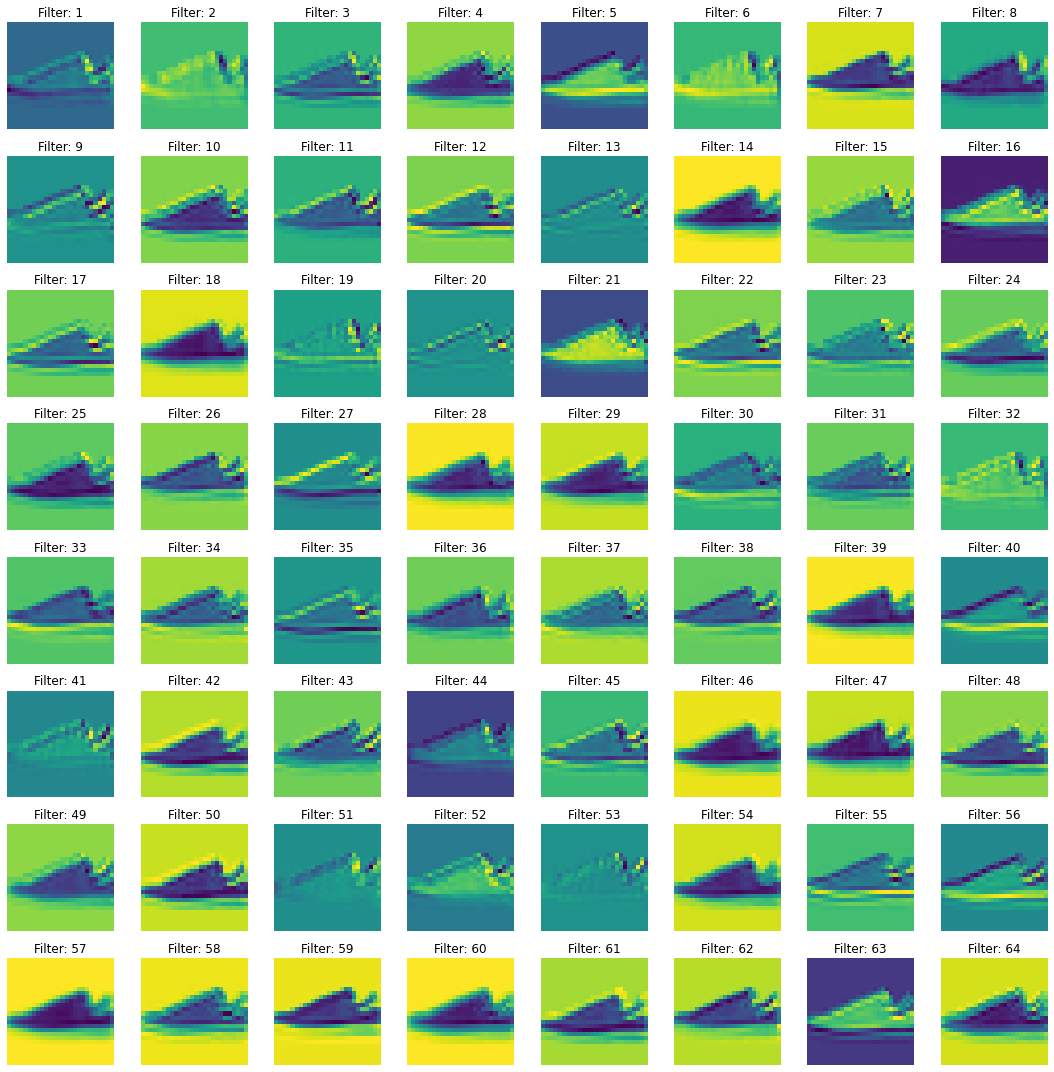

In [ ]:
fig, ax = plt.subplots(8, 8, figsize=(15,15))
for ix, axis in enumerate(ax.flat):
  axis.set_title('Filter: '+str(ix+1))
  axis.imshow(intermediate_output[ix].cpu())
  axis.axis('off')
plt.tight_layout()
plt.show()